In [1]:
import numpy as np
from sklearn.model_selection import KFold
import random
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms,models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from cnn_finetune import make_model
from sklearn.preprocessing import label_binarize
from itertools import cycle
import seaborn as sns

from sklearn.metrics import auc

from efficientnet_pytorch import EfficientNet
import torchvision.models as models

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# AlexNetモデルを事前学習済みモデルとしてロード
model = models.alexnet(pretrained=True)

# AlexNetの最終層の入力特徴量数を取得
num_ftrs = model.classifier[6].in_features

# 最終層を4クラスの出力に変更
model.classifier[6] = nn.Linear(num_ftrs, 4)

# すべての層を訓練可能に設定
for param in model.parameters():
    param.requires_grad = True

model = model.to(device)
print(model)

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [3]:
#データセットの設定
train_dataset = torchvision.datasets.ImageFolder(root='/home/yamaguchi/最終/GCB Non-GCB MALT Normal -最終/train')  #学習用データ：データ数は560
test_dataset  = torchvision.datasets.ImageFolder(root='/home/yamaguchi/最終/GCB Non-GCB MALT Normal -最終/test') 

transform = torchvision.transforms.Compose([
    transforms.RandomCrop((224,224)),
    # ランダムに画像を水平方向に反転
    transforms.RandomHorizontalFlip(),
    # ランダムに画像の色調を変更
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    # グレースケールに変換（3チャンネル出力）
    transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_2 = torchvision.transforms.Compose([
    transforms.RandomCrop((224,224)),
    # グレースケールに変換（3チャンネル出力）
    transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


batch_size = 32

train_dataset.transform=transform
test_dataset.transform=transform_2
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

print(train_dataset.classes)


['1 normal', '2 MALT', '3 GCB', '4 Non-GCB']


In [4]:
from torchsummary import summary

summary(model, (3, 224, 224))

#https://discuss.pytorch.org/t/what-is-1-in-output-shape-of-a-model-in-torch-summary/67790

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [5]:
# Train
def train(device, model, optimizer, criterion, cv_train_dataloader, cv_valid_dataloader):
    # Early stoppingの設定
    the_last_loss = 100  
    patience = 10
    trigger_times = 0

    for epoch in range(100):
        model.train()
        running_loss = 0.0
        correct_num = 0
        total_num = 0
        batch_count = 0

        for data,target in  cv_train_dataloader:
            inputs, labels = data.to(device), target.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            predicted = torch.max(outputs.data, 1)[1]
            correct_num_temp = (predicted==labels).sum()
            correct_num += correct_num_temp.item()
            total_num += data.shape[0]
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch_count += 1 

        print('epoch:%d loss: %.3f acc: %.3f' %
             (epoch + 1, running_loss / batch_count, correct_num*100/total_num))
            

        # Early stopping
        the_current_loss = validation(model, device, cv_valid_dataloader, criterion)
        print('The current loss:', the_current_loss)

        if the_current_loss > the_last_loss:
            trigger_times += 1
            print('trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                return model

        else:
            print('trigger times: 0')
            trigger_times = 0

        the_last_loss = the_current_loss

    return model

In [6]:
#validation

def validation(model, device, cv_valid_dataloader, criterion):
    model.eval()
    running_loss = 0

    with torch.no_grad():
        for data,target in cv_valid_dataloader:
            inputs, labels = data.to(device), target.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    return running_loss / len(cv_valid_dataloader)

In [7]:

def test(device, model, test_dataloader):
    model.eval()
    
    correct_num = 0
    total_num = 0
    predicts_list = []
    labels_list = []
    scores_list=[] 

    with torch.no_grad():
        for data, target in test_dataloader:
            inputs, labels = data.to(device), target.to(device)

            outputs = model(inputs)
            m = nn.Softmax(dim=1)
            probs = m(outputs)
            
            _, predicted = torch.max(outputs.data, 1)
            correct_num_temp = (predicted == labels).sum()
            correct_num += correct_num_temp.item()
            total_num += data.shape[0]

            device2 = torch.device('cpu')
            labels=labels.to(device2)
            predicted = predicted.to(device2)
            probs = probs.to(device2)

            labels_list.append(labels)
            predicts_list.append(predicted)
            scores_list.append(probs)  
    
        labels = torch.cat(labels_list)
        predicted = torch.cat(predicts_list)
        scores = torch.cat(scores_list)  

        labels_bin = label_binarize(labels, classes=[0, 1, 2, 3])  # Changed to four classes

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(4):  # Changed loop range to four classes
            fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], scores[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        C = confusion_matrix(labels, predicted)
        ac = accuracy_score(labels, predicted)
        pre = precision_score(labels, predicted, average='macro')
        re = recall_score(labels, predicted, average='macro')
        f1 = f1_score(labels, predicted, average='macro')

        AUC = roc_auc_score(labels, scores, multi_class='ovr')  

        print(C)
        print("\n")
        print("test accuracy : %.3f" % ac)
        print("test precison : %.3f" % pre)
        print("test recall : %.3f" % re)
        print("test f : %.3f" % f1)
        print("AUC : %.3f" %(AUC))

        for i in range(4):  # Changed loop range to four classes
            print("AUC for class {}: {:.3f}".format(i, roc_auc[i]))

        # Compute macro-average ROC curve and ROC area
        fpr_macro = dict()
        tpr_macro = dict()
        roc_auc_macro = dict()
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))  # Changed loop range to four classes
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(4):  # Changed loop range to four classes
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= 4  # Changed the denominator to four classes
        fpr_macro["macro"] = all_fpr
        tpr_macro["macro"] = mean_tpr
        roc_auc_macro["macro"] = auc(fpr_macro["macro"], tpr_macro["macro"])

        # Plot all ROC curves
        plt.figure()
        plt.plot(fpr_macro["macro"], tpr_macro["macro"],
                 label='macro-average ROC curve (area = {:.3g})'.format(roc_auc_macro["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])  # Added one more color for the additional class
        class_labels = ['Normal lymph node', 'MALT lymphoma', 'GCB', 'Non-GCB']  # Changed to four class labels
        for i, color in zip(range(4), colors):  # Changed loop range to four classes
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label='ROC curve of class {0} (area = {1:.3g})'
                     ''.format(class_labels[i], roc_auc[i]))

            
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        
        class_labels = ['normal lymph nodes', 'MALToma', 'GCB', 'non-GCB']   # Changed to four class labels
        C = confusion_matrix(labels, predicted)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(C, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels,annot_kws={'size': 20})
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
        plt.show()

            

In [8]:
#k分割交差検証

kf = KFold(n_splits=10)

Fold 1------------------------------------------------------------------------------
epoch:1 loss: 0.870 acc: 62.300
The current loss: 0.7455475186231302
trigger times: 0
epoch:2 loss: 0.732 acc: 68.097
The current loss: 0.631078082460987
trigger times: 0
epoch:3 loss: 0.655 acc: 71.744
The current loss: 0.5933823257444837
trigger times: 0
epoch:4 loss: 0.583 acc: 75.704
The current loss: 0.556139058659779
trigger times: 0
epoch:5 loss: 0.551 acc: 76.692
The current loss: 0.46844114492108885
trigger times: 0
epoch:6 loss: 0.495 acc: 79.295
The current loss: 0.41506067155981413
trigger times: 0
epoch:7 loss: 0.465 acc: 80.458
The current loss: 0.41291946599707774
trigger times: 0
epoch:8 loss: 0.442 acc: 81.436
The current loss: 0.4360312811945129
trigger times: 1
epoch:9 loss: 0.413 acc: 83.476
The current loss: 0.3268810889886618
trigger times: 0
epoch:10 loss: 0.404 acc: 83.495
The current loss: 0.44745320323164756
trigger times: 1
epoch:11 loss: 0.364 acc: 85.443
The current loss: 0

The current loss: 0.006689832221326858
trigger times: 0
epoch:94 loss: 0.038 acc: 98.625
The current loss: 0.03220478889291304
trigger times: 1
epoch:95 loss: 0.037 acc: 98.911
The current loss: 0.02836400017600933
trigger times: 0
epoch:96 loss: 0.038 acc: 98.763
The current loss: 0.0072745653750642516
trigger times: 0
epoch:97 loss: 0.033 acc: 98.828
The current loss: 0.01587437196534981
trigger times: 1
epoch:98 loss: 0.035 acc: 98.883
The current loss: 0.011561453150881012
trigger times: 0
epoch:99 loss: 0.033 acc: 98.865
The current loss: 0.014175124941486168
trigger times: 1
epoch:100 loss: 0.044 acc: 98.495
The current loss: 0.005587254064854002
trigger times: 0
[[ 87  12   3  48]
 [  0  12  29  81]
 [  0   3  55 152]
 [  0   0 101 379]]


test accuracy : 0.554
test precison : 0.578
test recall : 0.432
test f : 0.459
AUC : 0.795
AUC for class 0: 0.970
AUC for class 1: 0.917
AUC for class 2: 0.579
AUC for class 3: 0.716


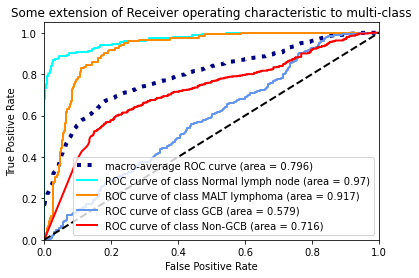

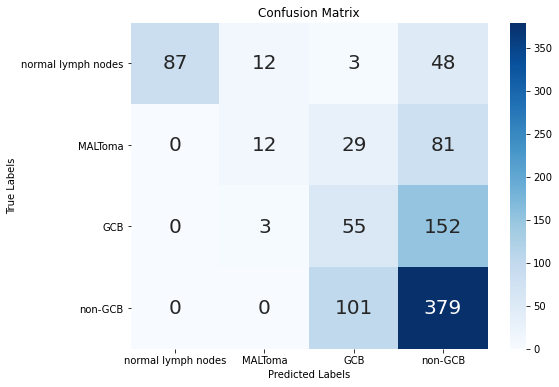

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 2------------------------------------------------------------------------------
epoch:1 loss: 0.858 acc: 62.587
The current loss: 0.7163361010737826
trigger times: 0
epoch:2 loss: 0.727 acc: 68.162
The current loss: 0.6576815815930939
trigger times: 0
epoch:3 loss: 0.625 acc: 72.787
The current loss: 0.5276204242077108
trigger times: 0
epoch:4 loss: 0.575 acc: 75.445
The current loss: 0.5657321143512316
trigger times: 1
epoch:5 loss: 0.531 acc: 78.113
The current loss: 0.5107954799762177
trigger times: 0
epoch:6 loss: 0.479 acc: 80.726
The current loss: 0.5086694887803543
trigger times: 0
epoch:7 loss: 0.460 acc: 81.039
The current loss: 0.3851128733342628
trigger times: 0
epoch:8 loss: 0.414 acc: 83.181
The current loss: 0.37084811843701937
trigger times: 0
epoch:9 loss: 0.420 acc: 83.199
The current loss: 0.3494342009562227
trigger times: 0
epoch:10 loss: 0.388 acc: 84.261
The current loss: 0.31033366148134367
trigger times: 0
epoch:11 loss: 0.375 acc: 84.972
The current loss: 0

The current loss: 0.0159914667527072
trigger times: 2
epoch:94 loss: 0.032 acc: 98.809
The current loss: 0.017679178010747486
trigger times: 3
epoch:95 loss: 0.031 acc: 98.975
The current loss: 0.1412510011235746
trigger times: 4
epoch:96 loss: 0.038 acc: 98.809
The current loss: 0.02015414981611722
trigger times: 0
epoch:97 loss: 0.037 acc: 98.698
The current loss: 0.0191513080034831
trigger times: 0
epoch:98 loss: 0.028 acc: 99.132
The current loss: 0.006901980579442249
trigger times: 0
epoch:99 loss: 0.049 acc: 98.431
The current loss: 0.006121530177096171
trigger times: 0
epoch:100 loss: 0.032 acc: 98.957
The current loss: 0.010139723680966722
trigger times: 1
[[ 97  21   2  30]
 [  0  19  36  67]
 [  0   3  59 148]
 [  0   0 111 369]]


test accuracy : 0.565
test precison : 0.582
test recall : 0.463
test f : 0.493
AUC : 0.822
AUC for class 0: 0.979
AUC for class 1: 0.911
AUC for class 2: 0.654
AUC for class 3: 0.744


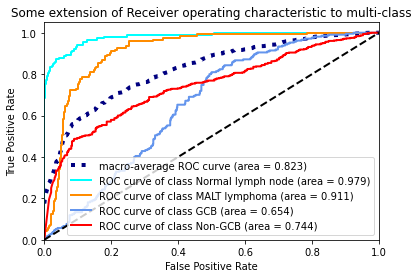

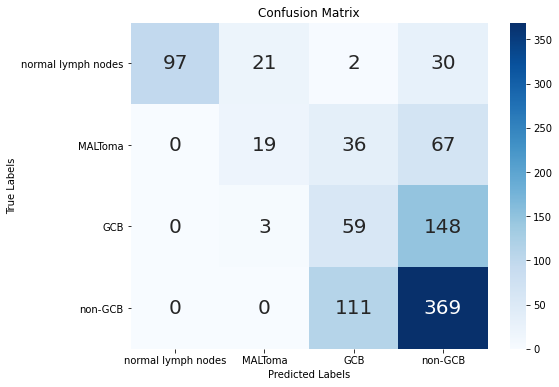

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 3------------------------------------------------------------------------------
epoch:1 loss: 0.873 acc: 62.023
The current loss: 0.7450720795229693
trigger times: 0
epoch:2 loss: 0.715 acc: 68.282
The current loss: 0.6366006852921571
trigger times: 0
epoch:3 loss: 0.634 acc: 72.888
The current loss: 0.573603338093887
trigger times: 0
epoch:4 loss: 0.572 acc: 76.110
The current loss: 0.43953382766787646
trigger times: 0
epoch:5 loss: 0.507 acc: 79.082
The current loss: 0.47041300756466686
trigger times: 1
epoch:6 loss: 0.490 acc: 79.692
The current loss: 0.41203662838871086
trigger times: 0
epoch:7 loss: 0.449 acc: 81.769
The current loss: 0.3444448682124466
trigger times: 0
epoch:8 loss: 0.421 acc: 82.895
The current loss: 0.3317926280302817
trigger times: 0
epoch:9 loss: 0.397 acc: 83.846
The current loss: 0.28488864058758023
trigger times: 0
epoch:10 loss: 0.377 acc: 84.870
The current loss: 0.3253231640476429
trigger times: 1
epoch:11 loss: 0.368 acc: 84.769
The current loss: 

The current loss: 0.018057966086014357
trigger times: 2
epoch:94 loss: 0.026 acc: 99.132
The current loss: 0.005187270761921987
trigger times: 0
epoch:95 loss: 0.039 acc: 98.661
The current loss: 0.01732442140042766
trigger times: 1
epoch:96 loss: 0.039 acc: 98.689
The current loss: 0.006050030821453447
trigger times: 0
epoch:97 loss: 0.033 acc: 98.902
The current loss: 0.005096640948230372
trigger times: 0
epoch:98 loss: 0.037 acc: 98.763
The current loss: 0.01738801767912368
trigger times: 1
epoch:99 loss: 0.038 acc: 98.634
The current loss: 0.005333459380039337
trigger times: 0
epoch:100 loss: 0.037 acc: 98.846
The current loss: 0.004213068573786501
trigger times: 0
[[ 88  22   3  37]
 [  0  28  28  66]
 [  0   2  51 157]
 [  1   4  89 386]]


test accuracy : 0.575
test precison : 0.596
test recall : 0.466
test f : 0.501
AUC : 0.810
AUC for class 0: 0.964
AUC for class 1: 0.902
AUC for class 2: 0.632
AUC for class 3: 0.742


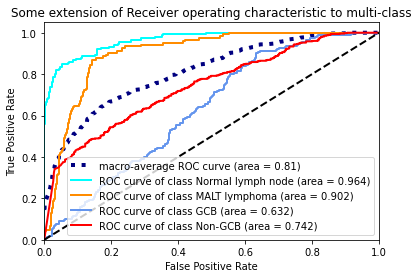

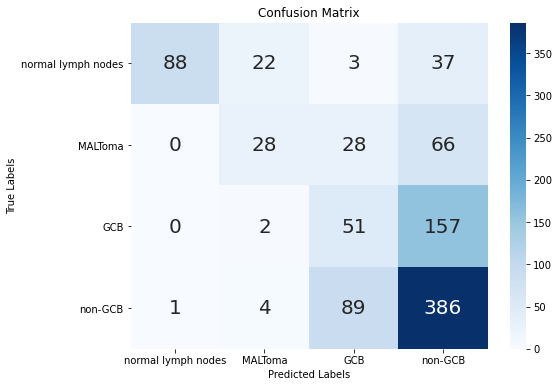

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 4------------------------------------------------------------------------------
epoch:1 loss: 0.873 acc: 61.285
The current loss: 0.7301312233348841
trigger times: 0
epoch:2 loss: 0.720 acc: 68.125
The current loss: 0.635604793072615
trigger times: 0
epoch:3 loss: 0.655 acc: 71.513
The current loss: 0.650283489753712
trigger times: 1
epoch:4 loss: 0.585 acc: 75.113
The current loss: 0.4591012684241003
trigger times: 0
epoch:5 loss: 0.551 acc: 77.153
The current loss: 0.5883804430160396
trigger times: 1
epoch:6 loss: 0.492 acc: 80.006
The current loss: 0.37324867358848973
trigger times: 0
epoch:7 loss: 0.454 acc: 81.150
The current loss: 0.361191111803615
trigger times: 0
epoch:8 loss: 0.435 acc: 82.415
The current loss: 0.3477946504397465
trigger times: 0
epoch:9 loss: 0.401 acc: 83.596
The current loss: 0.33092192105317525
trigger times: 0
epoch:10 loss: 0.376 acc: 85.129
The current loss: 0.3655390807136621
trigger times: 1
epoch:11 loss: 0.370 acc: 85.276
The current loss: 0.29

KeyboardInterrupt: 

In [9]:
%%time

def main():
    
    for _fold, (train_index, valid_index) in enumerate(kf.split(np.arange(len(train_dataset)))):
    
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # AlexNetモデルを事前学習済みモデルとしてロード
        model = models.alexnet(pretrained=True)

        # AlexNetの最終層の入力特徴量数を取得
        num_ftrs = model.classifier[6].in_features

        # 最終層を4クラスの出力に変更
        model.classifier[6] = nn.Linear(num_ftrs, 4)

        # すべての層を訓練可能に設定
        for param in model.parameters():
            param.requires_grad = True

        model = model.to(device)

        batch_size = 32
        criterion = nn.CrossEntropyLoss()
        # Pass all model parameters to the optimizer
        optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9) # Optimize the entire model for fine-tuning
        
        cv_train_dataset = Subset(train_dataset, train_index)
        cv_train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
        cv_valid_dataset   = Subset(train_dataset, valid_index)
        cv_valid_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)
        
        print('Fold {}------------------------------------------------------------------------------'.format(_fold+1))

        model = train(device, model, optimizer, criterion, cv_train_dataloader, cv_valid_dataloader)
        test(device, model, test_dataloader)


if __name__ == '__main__':
    main()